In [ ]:
!nvidia-smi

Mon Jan  6 01:06:17 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Pip install method (recommended)

!pip install "ultralytics<=8.3.40"

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 35.5/235.7 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
!pip install onnxruntime==1.18.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
# settings
MODEL = "yolov8x.pt"

In [ ]:
from google.colab import drive
drive.flush_and_unmount()  # Önce mevcut bağlantıyı kaldırın

drive.mount('/content/drive')  # Tekrar bağlanın


Mounted at /content/drive


In [ ]:
from ultralytics import YOLO  # YOLO sınıfını tanımla

# Modeli yükle
model = YOLO('/content/drive/MyDrive/deneme/experiment_name2/weights/best.pt')  # Eğitilmiş modelin tam yolunu yazın
model.fuse()  # Performans optimizasyonu


YOLOv5s summary (fused): 193 layers, 9,115,793 parameters, 0 gradients, 23.8 GFLOPs


In [ ]:
names = ['Cargo Minivan', 'Cargo Van', 'Motorcycle', 'Passenger Van', 'Pedestrian', 'Pickup Truck', 'Taxi', 'Tractor Trailer', 'bicycle', 'bus', 'cars']



0: 384x640 1 Passenger Van, 19 carss, 11.6ms
Speed: 3.2ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


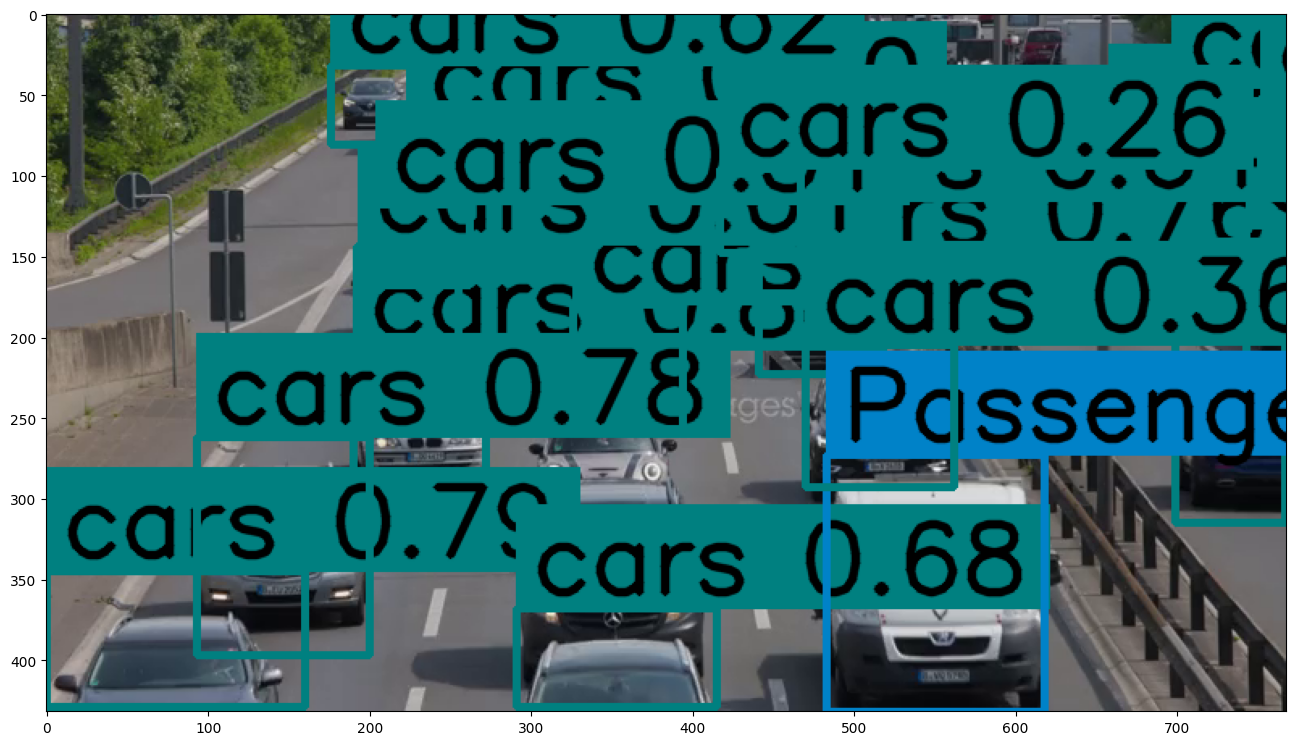

In [ ]:


# Modeli yükle
model = YOLO('/content/drive/MyDrive/deneme/experiment_name2/weights/best.pt')

# Video yolu
SOURCE_VIDEO_PATH = '/content/drive/MyDrive/deneme/otoban4.mp4'


# Sınıf isimlerini modelden al
CLASS_NAMES_DICT = model.model.names

# Video karelerini oluştur
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# Annotator oluştur
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

# İlk video karesini al
iterator = iter(generator)
frame = next(iterator)

# Model tahmini ve deteksiyonlara dönüştürme
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# Özel etiketleri formatla
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Kare üzerine annotasyonları ekle
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

# Notebook içinde görüntüyü göster
%matplotlib inline
show_frame_in_notebook(frame, (16, 16))


In [ ]:
LINE_START = Point(0, 200)
LINE_END = Point(800, 400)


TARGET_VIDEO_PATH = '/content/drive/MyDrive/deneme/otoban4_out.mp4'

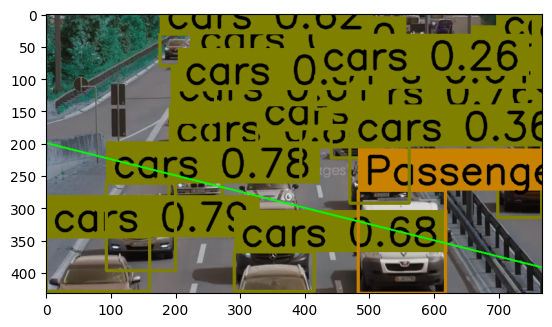

In [ ]:
# Çizgiyi görselleştirme
cv2.line(frame, (LINE_START.x, LINE_START.y), (LINE_END.x, LINE_END.y), (0, 255, 0), 2)
plt.imshow(frame)
plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt


In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=768, height=432, fps=24, total_frames=545)

In [ ]:
import numpy as np
np.float = float  # Geçici çözüm, NumPy'nin eski API'sine uyumluluk sağlar.


from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())

# Video bilgisi
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Video frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# Çizgi başlangıç ve bitiş noktaları
LINE_START = Point(0, 200)
LINE_END = Point(800, 400)
line_counter = LineCounter(start=LINE_START, end=LINE_END)

# Annotatorlar
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Yalnızca belirli sınıfları seçmek için CLASS_ID
CLASS_ID = list(range(11))  # Tüm sınıfları dahil etmek için

# Video çıktı dosyası
TARGET_VIDEO_PATH = '/content/drive/MyDrive/deneme/otoban4_out.mp4'

# Video işleme
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(generator, total=video_info.total_frames):
        # Model tahmini
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        # İstenmeyen sınıfları ve düşük doğruluk oranını filtreleme
        mask = np.array(
            [(class_id in CLASS_ID) and (confidence > 0.6) for class_id, confidence in zip(detections.class_id, detections.confidence)],
            dtype=bool
        )
        detections.filter(mask=mask, inplace=True)

        # Takip işlemleri
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)

        # Tracker ID'si olmayanları filtreleme
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        # Etiketleri formatlama
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id in detections
        ]

        # Çizgi sayacını güncelleme
        line_counter.update(detections=detections)

        # Kareyi annotate et
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)

        # Sonuçları video dosyasına yazma
        sink.write_frame(frame)


  0%|          | 0/620 [00:00<?, ?it/s]


0: 384x640 1 Passenger Van, 19 carss, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cargo Van, 1 Passenger Van, 18 carss, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Cargo Van, 1 Passenger Van, 19 carss, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Passenger Van, 19 carss, 10.8ms
Speed: 2.9ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Passenger Van, 1 Pickup Truck, 20 carss, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pickup Truck, 20 carss, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pickup Truck, 20 carss, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.3ms postprocess per i